# Explore the Raw Risk Free Data

In [62]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [63]:
from IPython.display import display
from pathlib import Path
from typing import Union, List, Iterable
import datetime
import sys
import os
import pandas as pd
import numpy as np
from sqlalchemy.sql import func
from selenium import webdriver
from lxml import html
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters


# from io import StringIO

import context
from config import default_settings
import src.Utility as Util
from src.Analytics.Options import find_risk_free_trade
from src.DataSource.sql_db import get_engine, session_factory, get_metadata, set_engine
from src.DataSource.sql_db.Common import get_or_create, condition_exists
from src.DataSource.sql_db.Models import (
    OptionPrice,
    StockPrice,
    LIBOR,
    OptionPrice,
    RateCPI,
)
from src.DataSource.Web.selenium_driver_utility import get_driver
from src.DataSource.Web.fidelity import (
    parsing_helpers,
    format_fidelity_option_df,
    sql_dtypes,
    sql_cols,
    web_cols,
    web_dtypes,
    web_to_sql_cols,
    init_option_webpage,
    load_nth_expiration_page,
    read_nth_option,
)
import matplotlib

register_matplotlib_converters()
sns.set()
%matplotlib inline
matplotlib.get_backend()

'module://ipykernel.pylab.backend_inline'

In [64]:
# initialize sql tables
engine = set_engine(
    Path(default_settings.data_dir, "MarketData.sqlite").resolve(), echo_parm=False
)
#    os.path.join(default_settings.data_dir, "MarketData.sqlite"), echo_parm=False)
session = session_factory()
metadata = get_metadata()
for t in metadata.sorted_tables:
    print(t)

setting the DB path to C:\Users\cp035982\Python\Projects\Personal\MarketAnalysis\Data\MarketData.sqlite
cpi_rates
libor
options
stock_price


## Load the data from notebook 01_...

In [65]:
df_raw = pd.read_csv(
    Path("./risk_free_data_raw.csv"),
    index_col=False,
    parse_dates=["quote_ts", "expiration"],
)
df_raw.tail()

tckr                   quote_ts expiration        option_type  \
170838  SPY 2020-01-15 09:27:47.833439 2020-01-17  protective_collar   
170839  SPY 2020-01-15 09:27:47.833439 2020-01-17  protective_collar   
170840  SPY 2020-01-22 09:29:08.528357 2020-01-24  protective_collar   
170841  SPY 2020-01-22 09:29:08.528357 2020-01-24  protective_collar   
170842  SPY 2020-01-27 09:34:18.790469 2020-01-31  protective_collar   

        stock_price       sell_symbol  sell_strike  sell_price  \
170838   328.489990    -SPY200117C327        327.0        2.14   
170839   328.489990  -SPY200117C325.5        325.5        3.38   
170840   332.459991  -SPY200124C331.5        331.5        1.63   
170841   332.459991    -SPY200124C332        332.0        1.29   
170842   323.640015    -SPY200131C325        325.0        2.21   

              buy_symbol  buy_strike  buy_price  max_loss  max_profit  \
170838    -SPY200117P327       327.0       0.58  0.070010    0.070010   
170839  -SPY200117P325.5       325.5       0.33  0.060010    0.060010   
170840  -SPY200124P331.5       331.5       0.61  0.060009    0.060009   
170841    -SPY200124P332       332.0       0.77  0.060009    0.060009   
170842    -SPY200131P325       325.0       3.46  0.109985    0.109985   

        initial_investment  ann_return  
170838          326.929990    1.024450  
170839          325.439990    1.021018  
170840          331.439991    1.020642  
170841          331.939991    1.020610  
170842          324.890015    1.020449

## Explore 

In [66]:
df_raw.option_type.unique()

array(['protective_collar'], dtype=object)

In [67]:
df_raw.shape

(170843, 15)

In [84]:
df_raw.loc[df_raw.sell_strike == df_raw.buy_strike, "option_type"] = "combo_collar"
td_to_expiration = (
    df_raw.expiration + pd.Timedelta(hours=15, minutes=30) - df_raw.quote_ts
)
df_raw["days_to_expiration"] = td_to_expiration / pd.to_timedelta(1, unit="D")
df_raw

tckr                   quote_ts expiration   option_type  stock_price  \
0       SPY 2018-01-10 10:17:26.358000 2018-01-12  combo_collar   273.910004   
1       SPY 2018-01-11 16:11:07.944000 2018-01-12  combo_collar   276.119995   
2       SPY 2018-01-11 16:11:07.944000 2018-01-12  combo_collar   276.119995   
3       SPY 2018-01-11 16:11:07.944000 2018-01-12  combo_collar   276.119995   
4       SPY 2018-01-11 16:11:07.944000 2018-01-12  combo_collar   276.119995   
...     ...                        ...        ...           ...          ...   
170838  SPY 2020-01-15 09:27:47.833439 2020-01-17  combo_collar   328.489990   
170839  SPY 2020-01-15 09:27:47.833439 2020-01-17  combo_collar   328.489990   
170840  SPY 2020-01-22 09:29:08.528357 2020-01-24  combo_collar   332.459991   
170841  SPY 2020-01-22 09:29:08.528357 2020-01-24  combo_collar   332.459991   
170842  SPY 2020-01-27 09:34:18.790469 2020-01-31  combo_collar   323.640015   

             sell_symbol  sell_strike  sell_price        buy_symbol  \
0         -SPY180112C274        274.0        0.66    -SPY180112P274   
1       -SPY180112C276.5        276.5        0.28  -SPY180112P276.5   
2       -SPY180112C273.5        273.5        2.73  -SPY180112P273.5   
3         -SPY180112C274        274.0        2.24    -SPY180112P274   
4       -SPY180112C274.5        274.5        1.76  -SPY180112P274.5   
...                  ...          ...         ...               ...   
170838    -SPY200117C327        327.0        2.14    -SPY200117P327   
170839  -SPY200117C325.5        325.5        3.38  -SPY200117P325.5   
170840  -SPY200124C331.5        331.5        1.63  -SPY200124P331.5   
170841    -SPY200124C332        332.0        1.29    -SPY200124P332   
170842    -SPY200131C325        325.0        2.21    -SPY200131P325   

        buy_strike  buy_price  max_loss  max_profit  initial_investment  \
0            274.0       0.70  0.049996    0.049996          273.950004   
1            276.5       0.56  0.100005    0.100005          276.399995   
2            273.5       0.03  0.080005    0.080005          273.419995   
3            274.0       0.04  0.080005    0.080005          273.919995   
4            274.5       0.06  0.080005    0.080005          274.419995   
...            ...        ...       ...         ...                 ...   
170838       327.0       0.58  0.070010    0.070010          326.929990   
170839       325.5       0.33  0.060010    0.060010          325.439990   
170840       331.5       0.61  0.060009    0.060009          331.439991   
170841       332.0       0.77  0.060009    0.060009          331.939991   
170842       325.0       3.46  0.109985    0.109985          324.890015   

        ann_return  days_to_expiration  
0         1.021127            2.217056  
1         1.099203            0.971436  
2         1.079499            0.971436  
3         1.079348            0.971436  
4         1.079198            0.971436  
...            ...                 ...  
170838    1.024450            2.251530  
170839    1.021018            2.251530  
170840    1.020642            2.250596  
170841    1.020610            2.250596  
170842    1.020449            4.247005  

[170843 rows x 16 columns]

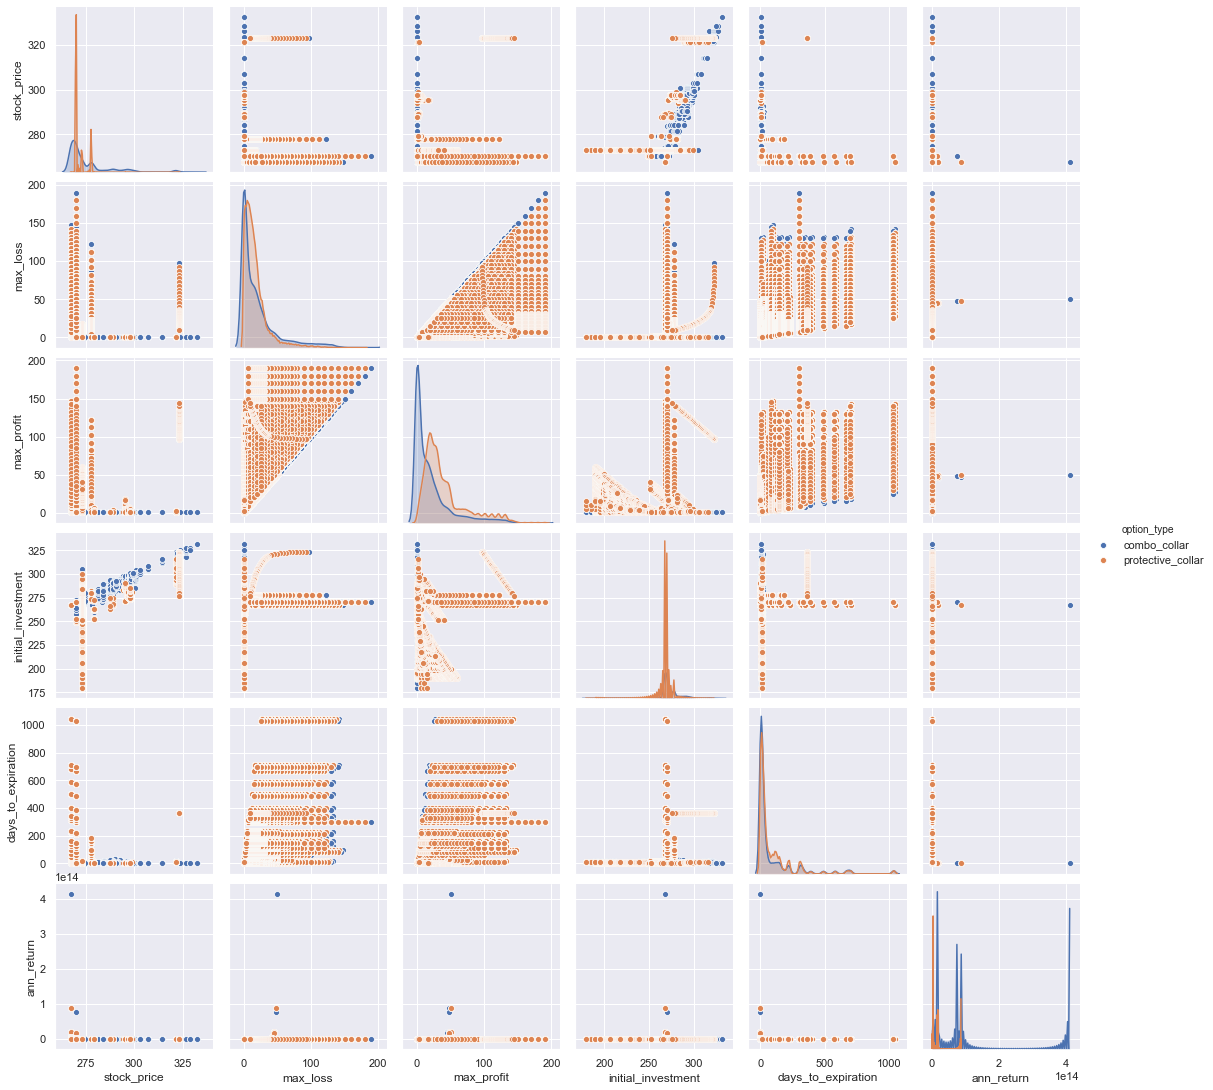

In [85]:
quote_time = pd.DatetimeIndex(df_raw.quote_ts).time
sns.pairplot(
    df_raw.loc[
        np.logical_and(
            pd.DatetimeIndex(df_raw.quote_ts).weekday < 4,
            np.logical_and(
                quote_time >= datetime.time(hour=8, minute=30),
                quote_time <= datetime.time(hour=15, minute=30),
            ),
        ),
        [
            "option_type",
            "stock_price",
            "max_loss",
            "max_profit",
            "initial_investment",
            "days_to_expiration",
            "ann_return",
        ],
    ],
    hue="option_type",
)

### Filter down to relevant data
* remove options with the buy_price == 0 as suspicious
* remove options where the quote price is outside of the market hours


In [68]:
valid_buy_price = df_raw.buy_price > 0
is_business_day = (
    pd.DatetimeIndex(df_raw.quote_ts).weekday < 4
)  # saturday will be 5 and sunday will be 6
quote_time = pd.DatetimeIndex(df_raw.quote_ts).time
during_market_hours = np.logical_and(
    quote_time >= datetime.time(hour=8, minute=30),
    quote_time <= datetime.time(hour=15, minute=30),
)  # between 9AM and 3:30PM (assumes central time)
del quote_time
df = df_raw.loc[
    np.logical_and(
        valid_buy_price, np.logical_and(is_business_day, during_market_hours)
    ),
    :,
].copy()
df

tckr                   quote_ts expiration        option_type  \
0       SPY 2018-01-10 10:17:26.358000 2018-01-12  protective_collar   
14936   SPY 2018-01-17 08:46:03.494000 2018-01-17  protective_collar   
14937   SPY 2018-01-17 08:46:03.494000 2018-01-17  protective_collar   
14938   SPY 2018-01-17 08:46:03.494000 2018-01-17  protective_collar   
14939   SPY 2018-01-17 08:46:03.494000 2018-01-17  protective_collar   
...     ...                        ...        ...                ...   
170838  SPY 2020-01-15 09:27:47.833439 2020-01-17  protective_collar   
170839  SPY 2020-01-15 09:27:47.833439 2020-01-17  protective_collar   
170840  SPY 2020-01-22 09:29:08.528357 2020-01-24  protective_collar   
170841  SPY 2020-01-22 09:29:08.528357 2020-01-24  protective_collar   
170842  SPY 2020-01-27 09:34:18.790469 2020-01-31  protective_collar   

        stock_price       sell_symbol  sell_strike  sell_price  \
0        273.910004    -SPY180112C274        274.0        0.66   
14936    277.769989    -SPY180117C273        273.0        4.82   
14937    277.769989    -SPY180117C278        278.0        0.41   
14938    277.769989    -SPY180117C273        273.0        4.82   
14939    277.769989    -SPY180117C273        273.0        4.82   
...             ...               ...          ...         ...   
170838   328.489990    -SPY200117C327        327.0        2.14   
170839   328.489990  -SPY200117C325.5        325.5        3.38   
170840   332.459991  -SPY200124C331.5        331.5        1.63   
170841   332.459991    -SPY200124C332        332.0        1.29   
170842   323.640015    -SPY200131C325        325.0        2.21   

              buy_symbol  buy_strike  buy_price  max_loss  max_profit  \
0         -SPY180112P274       274.0       0.70  0.049996    0.049996   
14936     -SPY180117P273       273.0       0.01  0.040011    0.040011   
14937     -SPY180117P278       278.0       0.60  0.040011    0.040011   
14938   -SPY180117P274.5       274.5       0.02  0.030011    1.530011   
14939   -SPY180117P273.5       273.5       0.02  0.030011    0.530011   
...                  ...         ...        ...       ...         ...   
170838    -SPY200117P327       327.0       0.58  0.070010    0.070010   
170839  -SPY200117P325.5       325.5       0.33  0.060010    0.060010   
170840  -SPY200124P331.5       331.5       0.61  0.060009    0.060009   
170841    -SPY200124P332       332.0       0.77  0.060009    0.060009   
170842    -SPY200131P325       325.0       3.46  0.109985    0.109985   

        initial_investment  ann_return  
0               273.950004    1.021127  
14936           272.959989    1.141927  
14937           277.959989    1.139204  
14938           272.969989    1.104669  
14939           272.969989    1.104669  
...                    ...         ...  
170838          326.929990    1.024450  
170839          325.439990    1.021018  
170840          331.439991    1.020642  
170841          331.939991    1.020610  
170842          324.890015    1.020449  

[7558 rows x 15 columns]

In [69]:
df.loc[df.sell_strike == df.buy_strike, "option_type"] = "combo_collar"
td_to_expiration = df.expiration + pd.Timedelta(hours=15, minutes=30) - df.quote_ts
df["days_to_expiration"] = td_to_expiration / pd.to_timedelta(1, unit="D")
df

tckr                   quote_ts expiration        option_type  \
0       SPY 2018-01-10 10:17:26.358000 2018-01-12       combo_collar   
14936   SPY 2018-01-17 08:46:03.494000 2018-01-17       combo_collar   
14937   SPY 2018-01-17 08:46:03.494000 2018-01-17       combo_collar   
14938   SPY 2018-01-17 08:46:03.494000 2018-01-17  protective_collar   
14939   SPY 2018-01-17 08:46:03.494000 2018-01-17  protective_collar   
...     ...                        ...        ...                ...   
170838  SPY 2020-01-15 09:27:47.833439 2020-01-17       combo_collar   
170839  SPY 2020-01-15 09:27:47.833439 2020-01-17       combo_collar   
170840  SPY 2020-01-22 09:29:08.528357 2020-01-24       combo_collar   
170841  SPY 2020-01-22 09:29:08.528357 2020-01-24       combo_collar   
170842  SPY 2020-01-27 09:34:18.790469 2020-01-31       combo_collar   

        stock_price       sell_symbol  sell_strike  sell_price  \
0        273.910004    -SPY180112C274        274.0        0.66   
14936    277.769989    -SPY180117C273        273.0        4.82   
14937    277.769989    -SPY180117C278        278.0        0.41   
14938    277.769989    -SPY180117C273        273.0        4.82   
14939    277.769989    -SPY180117C273        273.0        4.82   
...             ...               ...          ...         ...   
170838   328.489990    -SPY200117C327        327.0        2.14   
170839   328.489990  -SPY200117C325.5        325.5        3.38   
170840   332.459991  -SPY200124C331.5        331.5        1.63   
170841   332.459991    -SPY200124C332        332.0        1.29   
170842   323.640015    -SPY200131C325        325.0        2.21   

              buy_symbol  buy_strike  buy_price  max_loss  max_profit  \
0         -SPY180112P274       274.0       0.70  0.049996    0.049996   
14936     -SPY180117P273       273.0       0.01  0.040011    0.040011   
14937     -SPY180117P278       278.0       0.60  0.040011    0.040011   
14938   -SPY180117P274.5       274.5       0.02  0.030011    1.530011   
14939   -SPY180117P273.5       273.5       0.02  0.030011    0.530011   
...                  ...         ...        ...       ...         ...   
170838    -SPY200117P327       327.0       0.58  0.070010    0.070010   
170839  -SPY200117P325.5       325.5       0.33  0.060010    0.060010   
170840  -SPY200124P331.5       331.5       0.61  0.060009    0.060009   
170841    -SPY200124P332       332.0       0.77  0.060009    0.060009   
170842    -SPY200131P325       325.0       3.46  0.109985    0.109985   

        initial_investment  ann_return  days_to_expiration  
0               273.950004    1.021127            2.217056  
14936           272.959989    1.141927            0.280515  
14937           277.959989    1.139204            0.280515  
14938           272.969989    1.104669            0.280515  
14939           272.969989    1.104669            0.280515  
...                    ...         ...                 ...  
170838          326.929990    1.024450            2.251530  
170839          325.439990    1.021018            2.251530  
170840          331.439991    1.020642            2.250596  
170841          331.939991    1.020610            2.250596  
170842          324.890015    1.020449            4.247005  

[7558 rows x 16 columns]

In [70]:
df.columns

Index(['tckr', 'quote_ts', 'expiration', 'option_type', 'stock_price',
       'sell_symbol', 'sell_strike', 'sell_price', 'buy_symbol', 'buy_strike',
       'buy_price', 'max_loss', 'max_profit', 'initial_investment',
       'ann_return', 'days_to_expiration'],
      dtype='object')

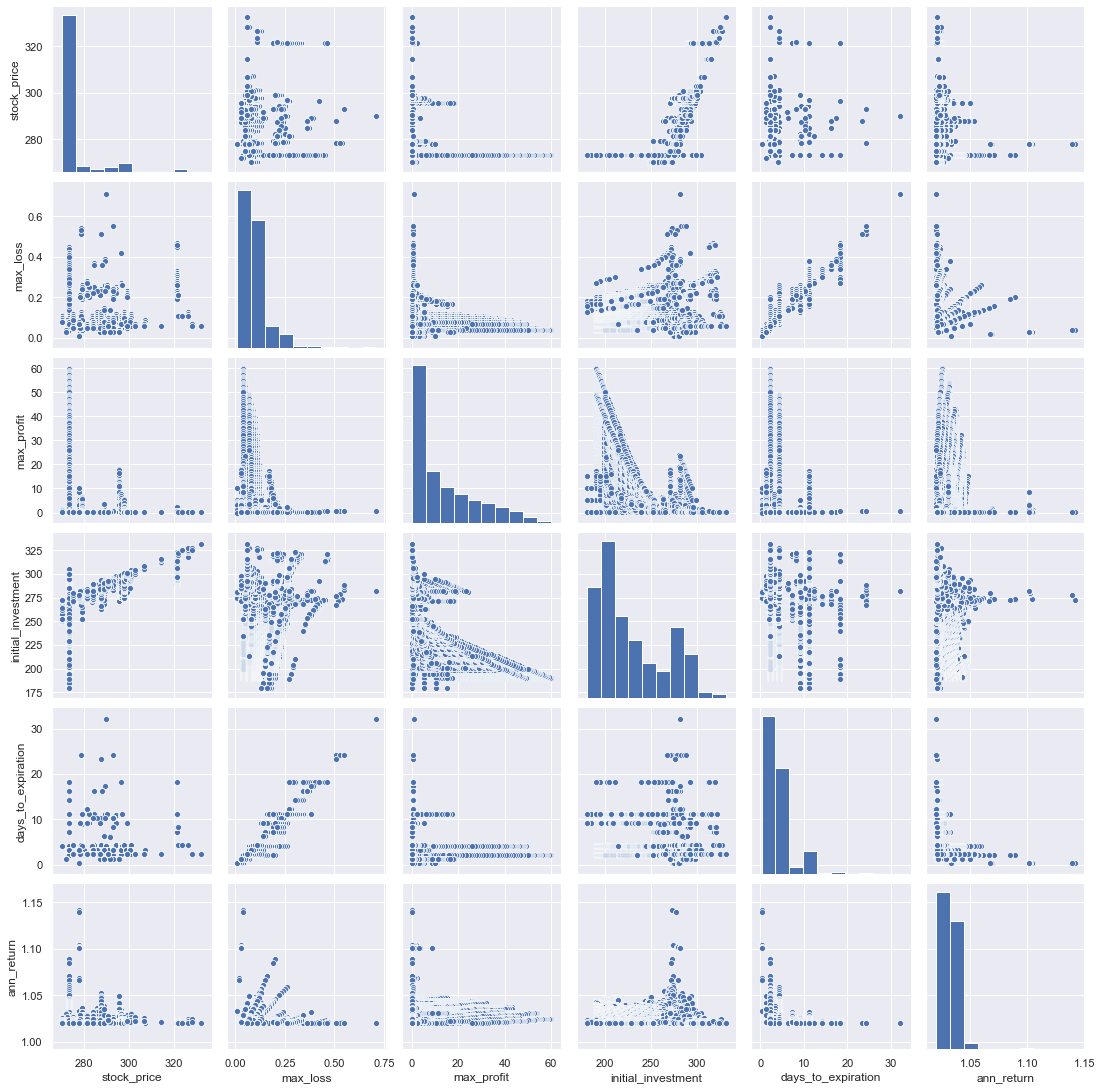

In [81]:
sns.pairplot(
    df[
        [
            "stock_price",
            "max_loss",
            "max_profit",
            "initial_investment",
            "days_to_expiration",
            "ann_return",
        ]
    ]
)

In [74]:
gt8 = df.loc[df.ann_return > 1.08, :].copy()
gt8.sort_values("ann_return", ascending=False)

tckr                quote_ts expiration        option_type  \
14936   SPY 2018-01-17 08:46:03.494 2018-01-17       combo_collar   
14937   SPY 2018-01-17 08:46:03.494 2018-01-17       combo_collar   
14938   SPY 2018-01-17 08:46:03.494 2018-01-17  protective_collar   
14939   SPY 2018-01-17 08:46:03.494 2018-01-17  protective_collar   
14940   SPY 2018-01-17 08:46:03.494 2018-01-17  protective_collar   
14941   SPY 2018-01-17 08:46:03.494 2018-01-17  protective_collar   
14942   SPY 2018-01-17 08:46:03.494 2018-01-17  protective_collar   
14943   SPY 2018-01-17 08:46:03.494 2018-01-17       combo_collar   
14944   SPY 2018-01-17 08:46:03.494 2018-01-17  protective_collar   
14945   SPY 2018-01-17 08:46:03.494 2018-01-17       combo_collar   
14946   SPY 2018-01-17 08:46:03.494 2018-01-17       combo_collar   
14947   SPY 2018-01-17 08:46:03.494 2018-01-17       combo_collar   
14948   SPY 2018-01-17 08:46:03.494 2018-01-17       combo_collar   
14949   SPY 2018-01-17 08:46:03.494 2018-01-17  protective_collar   
14950   SPY 2018-01-17 08:46:03.494 2018-01-17  protective_collar   
14951   SPY 2018-01-17 08:46:03.494 2018-01-17  protective_collar   
14952   SPY 2018-01-17 08:46:03.494 2018-01-17  protective_collar   
14953   SPY 2018-01-17 08:46:03.494 2018-01-17  protective_collar   
14954   SPY 2018-01-17 08:46:03.494 2018-01-17       combo_collar   
14955   SPY 2018-01-17 08:46:03.494 2018-01-17  protective_collar   
14956   SPY 2018-01-17 08:46:03.494 2018-01-17  protective_collar   
14957   SPY 2018-01-17 08:46:03.494 2018-01-17  protective_collar   
114190  SPY 2018-02-19 11:06:14.043 2018-02-21       combo_collar   
114191  SPY 2018-02-19 11:06:14.043 2018-02-21       combo_collar   
114192  SPY 2018-02-19 11:06:14.043 2018-02-21       combo_collar   

        stock_price       sell_symbol  sell_strike  sell_price  \
14936    277.769989    -SPY180117C273        273.0        4.82   
14937    277.769989    -SPY180117C278        278.0        0.41   
14938    277.769989    -SPY180117C273        273.0        4.82   
14939    277.769989    -SPY180117C273        273.0        4.82   
14940    277.769989    -SPY180117C273        273.0        4.82   
14941    277.769989  -SPY180117C273.5        273.5        4.32   
14942    277.769989  -SPY180117C273.5        273.5        4.32   
14943    277.769989  -SPY180117C273.5        273.5        4.32   
14944    277.769989    -SPY180117C274        274.0        3.82   
14945    277.769989    -SPY180117C274        274.0        3.82   
14946    277.769989    -SPY180117C279        279.0        0.10   
14947    277.769989  -SPY180117C279.5        279.5        0.04   
14948    277.769989    -SPY180117C280        280.0        0.02   
14949    277.769989    -SPY180117C282        282.0        0.00   
14950    277.769989  -SPY180117C282.5        282.5        0.00   
14951    277.769989  -SPY180117C283.5        283.5        0.00   
14952    277.769989    -SPY180117C283        283.0        0.00   
14953    277.769989    -SPY180117C284        284.0        0.00   
14954    277.769989  -SPY180117C281.5        281.5        0.00   
14955    277.769989    -SPY180117C285        285.0        0.00   
14956    277.769989  -SPY180117C284.5        284.5        0.00   
14957    277.769989    -SPY180117C290        290.0        0.00   
114190   273.109985    -SPY180221C273        273.0        1.78   
114191   273.109985  -SPY180221C273.5        273.5        1.49   
114192   273.109985  -SPY180221C272.5        272.5        2.09   

              buy_symbol  buy_strike  buy_price  max_loss  max_profit  \
14936     -SPY180117P273       273.0       0.01  0.040011    0.040011   
14937     -SPY180117P278       278.0       0.60  0.040011    0.040011   
14938   -SPY180117P274.5       274.5       0.02  0.030011    1.530011   
14939   -SPY180117P273.5       273.5       0.02  0.030011    0.530011   
14940     -SPY180117P274       274.0       0.02  0.030011    1.030011   
14941     -SPY180117P274       274.0       0.02  0.030011

In [76]:
gt8.dtypes

tckr                          object
quote_ts              datetime64[ns]
expiration            datetime64[ns]
option_type                   object
stock_price                  float64
sell_symbol                   object
sell_strike                  float64
sell_price                   float64
buy_symbol                    object
buy_strike                   float64
buy_price                    float64
max_loss                     float64
max_profit                   float64
initial_investment           float64
ann_return                   float64
days_to_expiration           float64
dtype: object

C:\Users\cp035982\bin\Continuum\envs\Markets\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

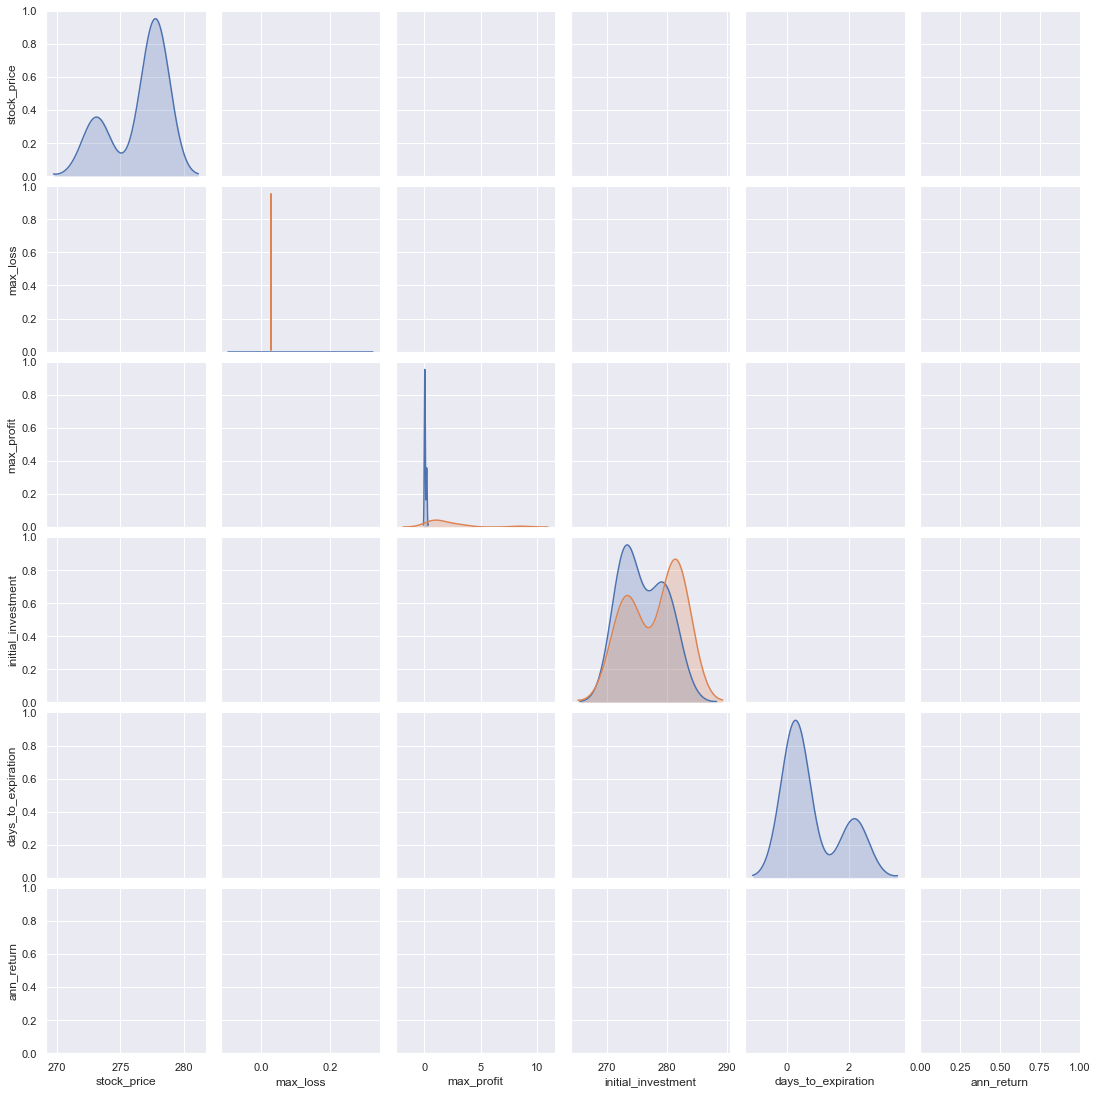

In [75]:
sns.pairplot(
    gt8[
        [
            'option_type',
            "stock_price",
            "max_loss",
            "max_profit",
            "initial_investment",
            "days_to_expiration",
            "ann_return",
        ]
    ],
    hue="option_type",
)